In [10]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Concatenate, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


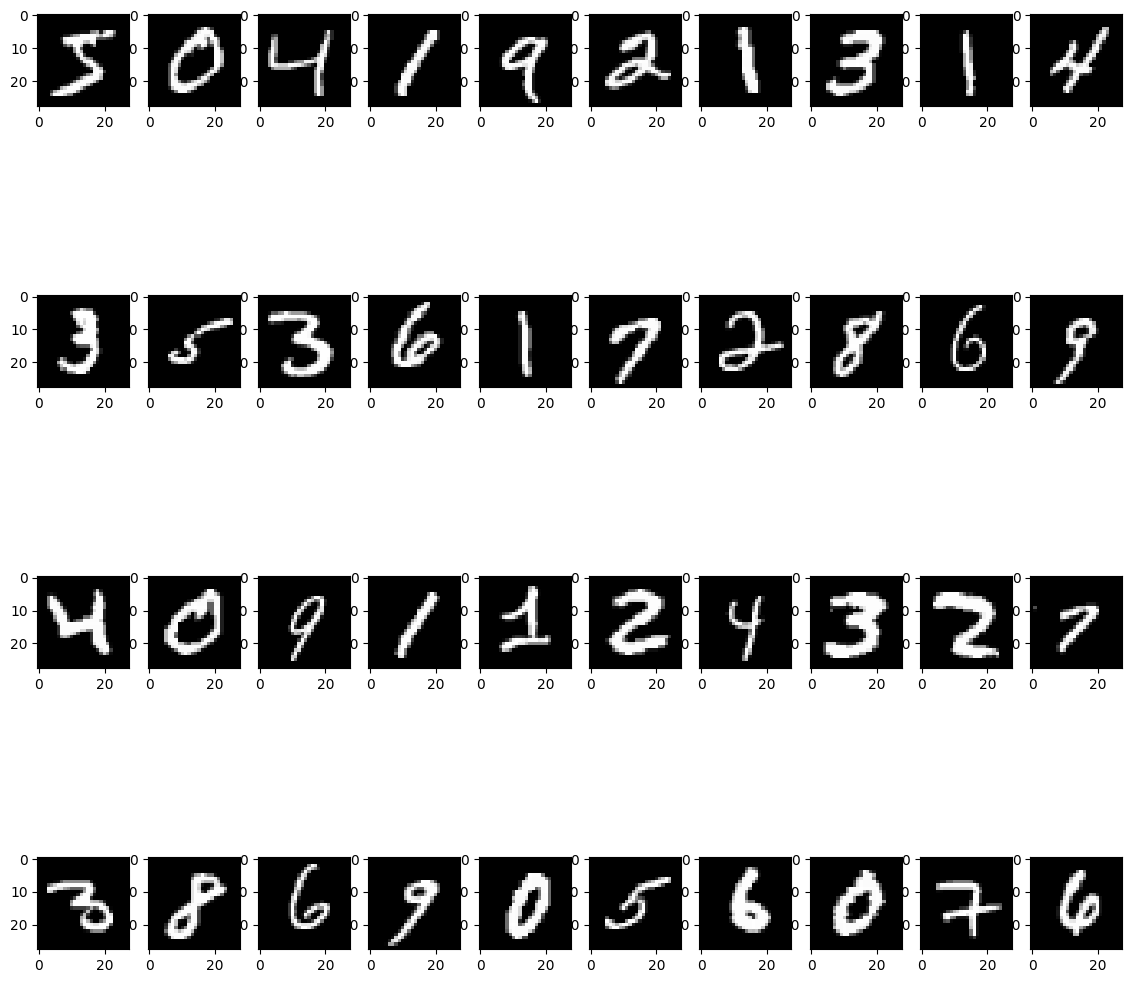

In [11]:
# MNIST veri setinin yüklenmesi
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Veri görselleştirme
plt.figure(figsize=(14,14))
x, y = 10, 4
for i in range(40):
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i], cmap='gray')
plt.show()


In [12]:
# Veri ön işleme
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Sınıf vektörlerini kategorik hale getirme
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [13]:
def dense_block(x, num_layers, growth_rate, name):
    """
    Dense Block fonksiyonu.
    """
    for i in range(num_layers):
        cb = conv_block(x, growth_rate, name=name+'_block'+str(i+1))
        x = Concatenate()([x, cb])
    return x

def conv_block(x, growth_rate, name):
    """
    Convolutional Block fonksiyonu.
    """
    x = BatchNormalization(name=name+'_bn')(x)
    x = Activation('relu', name=name+'_relu')(x)
    x = Conv2D(4 * growth_rate, 1, name=name+'_conv1')(x)
    x = BatchNormalization(name=name+'_bn2')(x)
    x = Activation('relu', name=name+'_relu2')(x)
    x = Conv2D(growth_rate, 3, padding='same', name=name+'_conv2')(x)
    return x

def transition_layer(x, reduction, name):
    """
    Transition Layer fonksiyonu.
    """
    x = BatchNormalization(name=name+'_bn')(x)
    x = Activation('relu', name=name+'_relu')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), 1, name=name+'_conv')(x)
    x = AveragePooling2D(2, strides=2, name=name+'_pool')(x)
    return x


In [14]:
def build_densenet(input_shape, num_classes, growth_rate=12, num_blocks=3, num_layers_per_block=4, reduction=0.5):
    """
    DenseNet modelini inşa eden fonksiyon.
    """
    inputs = Input(shape=input_shape)
    x = Conv2D(2 * growth_rate, 7, strides=2, padding='same', name='initial_conv')(inputs)
    x = MaxPooling2D(3, strides=2, padding='same', name='initial_pool')(x)

    for i in range(num_blocks):
        x = dense_block(x, num_layers_per_block, growth_rate, name='dense'+str(i+1))
        if i != num_blocks - 1:
            x = transition_layer(x, reduction, name='trans'+str(i+1))

    x = BatchNormalization(name='final_bn')(x)
    x = Activation('relu', name='final_relu')(x)
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dense(num_classes, activation='softmax', name='fc')(x)

    model = Model(inputs, x, name='densenet')
    return model

input_shape = (28, 28, 1)
num_classes = 10
model = build_densenet(input_shape, num_classes)


In [15]:

# Modelin derlenmesi
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modelin eğitilmesi
history = model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=1, validation_data=(x_test, y_test))


Epoch 1/30
469/469 [==============================] - 26s 25ms/step - loss: 0.2372 - accuracy: 0.9311 - val_loss: 0.1015 - val_accuracy: 0.9714
Epoch 2/30
469/469 [==============================] - 11s 22ms/step - loss: 0.0582 - accuracy: 0.9828 - val_loss: 0.0556 - val_accuracy: 0.9826
Epoch 3/30
469/469 [==============================] - 10s 22ms/step - loss: 0.0393 - accuracy: 0.9877 - val_loss: 0.0408 - val_accuracy: 0.9871
Epoch 4/30
469/469 [==============================] - 10s 22ms/step - loss: 0.0318 - accuracy: 0.9902 - val_loss: 0.0594 - val_accuracy: 0.9815
Epoch 5/30
469/469 [==============================] - 10s 21ms/step - loss: 0.0260 - accuracy: 0.9920 - val_loss: 0.0380 - val_accuracy: 0.9877
Epoch 6/30
469/469 [==============================] - 12s 25ms/step - loss: 0.0222 - accuracy: 0.9931 - val_loss: 0.0407 - val_accuracy: 0.9873
Epoch 7/30
469/469 [==============================] - 11s 23ms/step - loss: 0.0219 - accuracy: 0.9927 - val_loss: 0.0568 - val_accuracy:

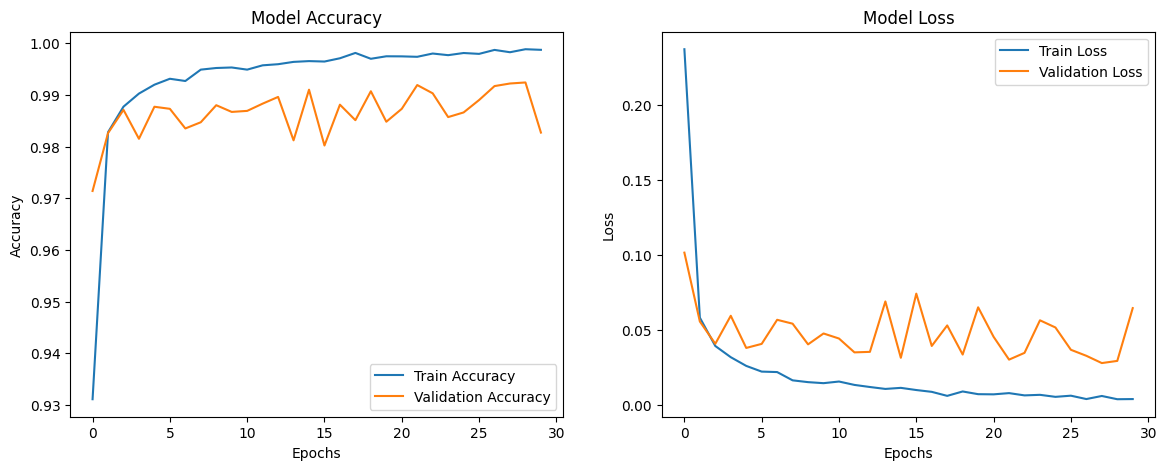

313/313 [==============================] - 2s 5ms/step


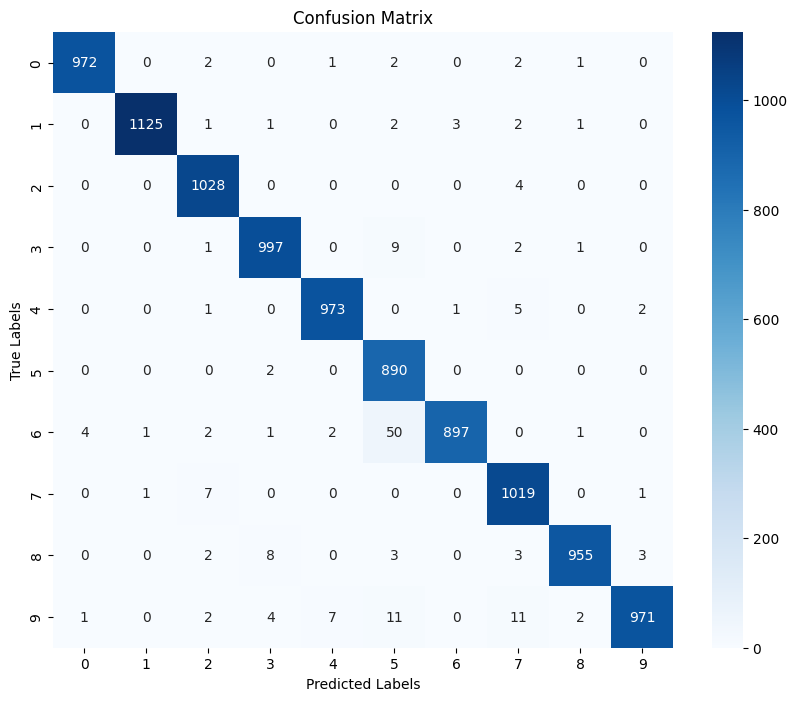

In [16]:
# Eğitim ve doğrulama doğruluğu ile kayıplarının saklanması
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Eğitim ve doğrulama sonuçlarının görselleştirilmesi
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion matrix hesaplanması
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Confusion matrix görselleştirilmesi
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
